In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

In [23]:
from utils import apply_threshholding, \
                    get_hsv_color_range, \
                    gradient_magnitude, \
                    plot_all_images, \
                    sobel_filter, \
                    undistort_and_save_image

In [24]:
out = './output_images/'

In [25]:
test_images_path = glob.glob('./test_images/*_dst.jpg')
test_images_path

['./test_images/straight_lines1_dst.jpg',
 './test_images/test2_dst.jpg',
 './test_images/test6_dst.jpg',
 './test_images/test3_dst.jpg',
 './test_images/test1_dst.jpg',
 './test_images/test4_dst.jpg',
 './test_images/straight_lines2_dst.jpg',
 './test_images/test5_dst.jpg']

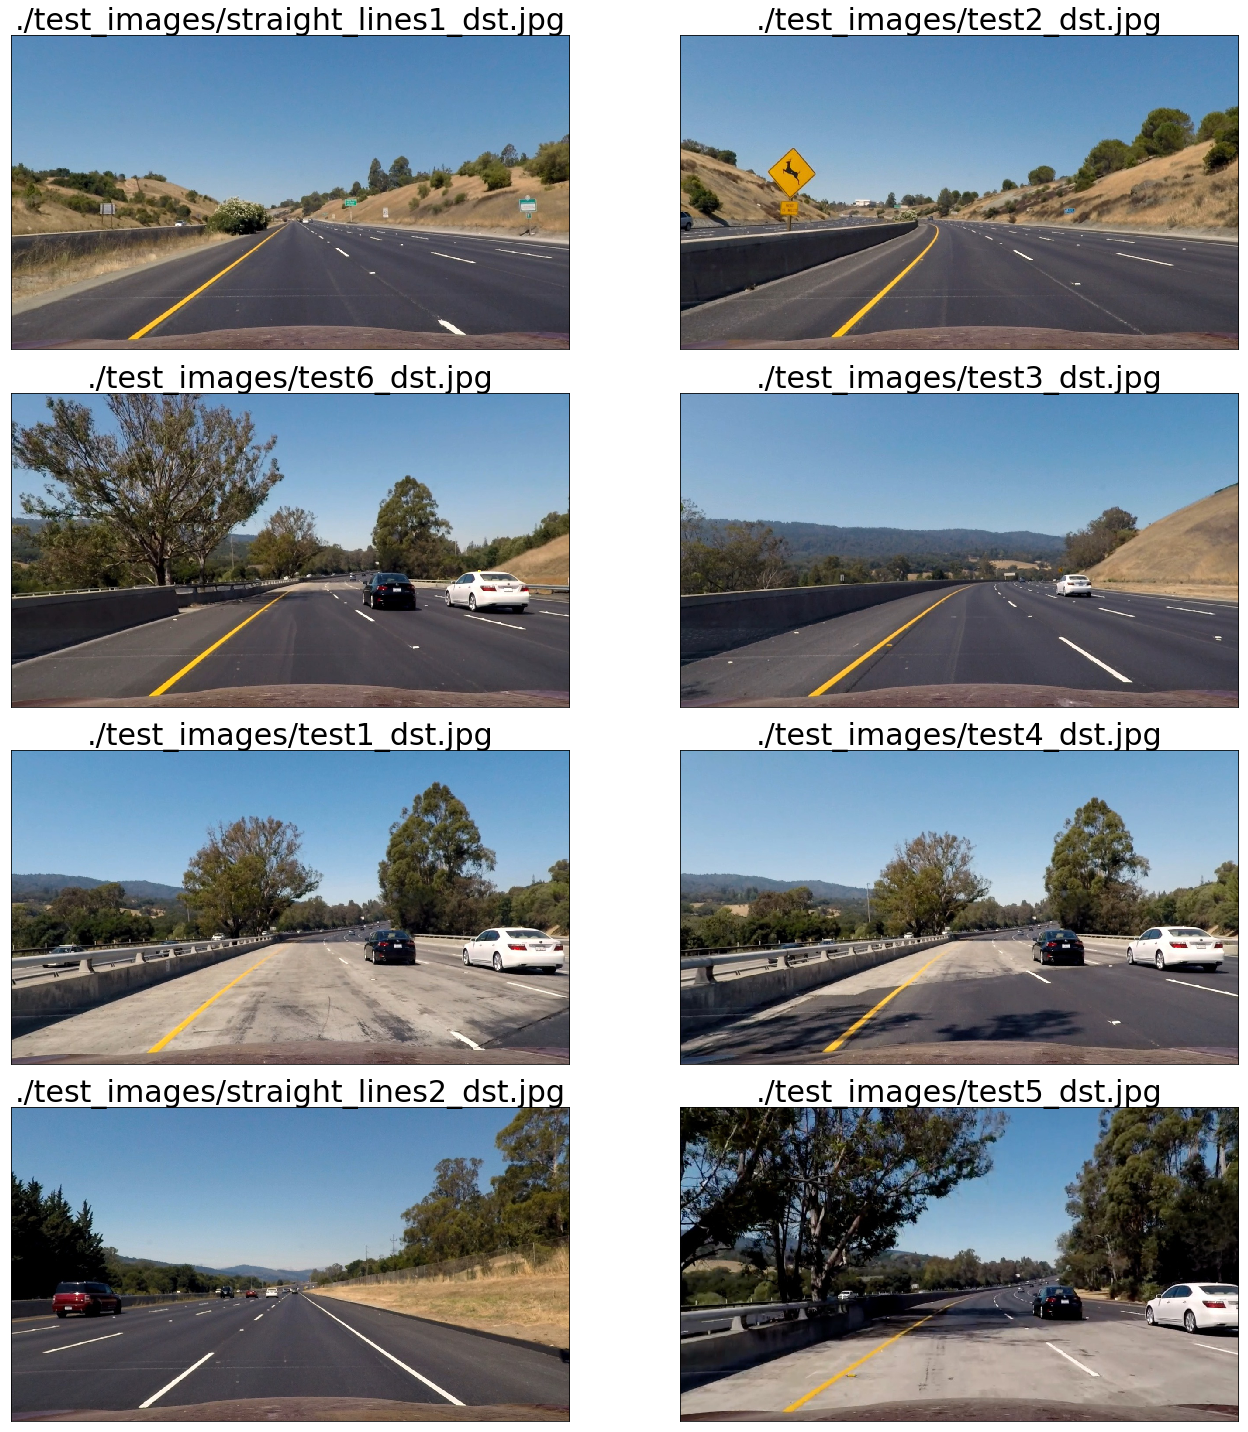

In [26]:
plot_all_images(test_images_path)

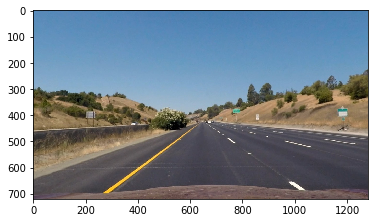

In [28]:
plt.imshow(
    cv2.cvtColor(
        cv2.imread('./test_images/straight_lines1_dst.jpg'),
        cv2.COLOR_BGR2RGB
    )
)
plt.savefig(out + 'lane_line_undistort_straight1.png')

## apply some binary mask search

In [8]:
cfg = {}

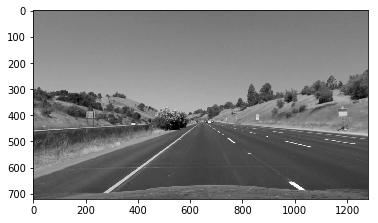

In [9]:
img = cv2.imread('./test_images/straight_lines1_dst.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

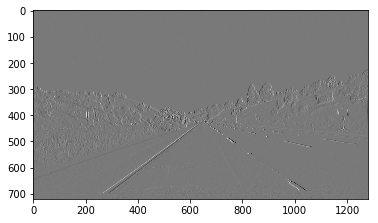

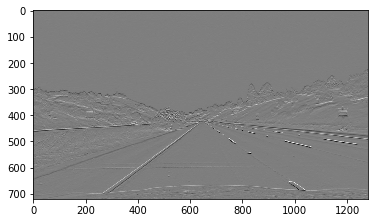

In [10]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

plt.imshow(sobelx, cmap='gray'); plt.show()
plt.imshow(sobely, cmap='gray'); plt.show()

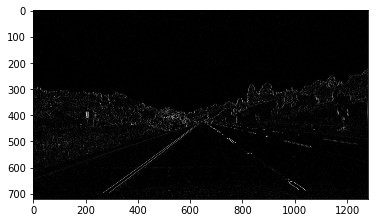

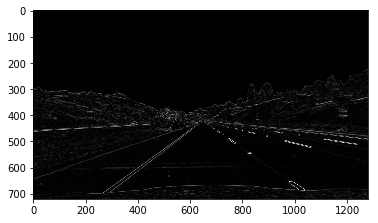

In [29]:
sobelx_norm = sobel_filter(sobelx)
sobely_norm = sobel_filter(sobely)

plt.imshow(sobelx_norm, cmap='gray'); plt.show(); plt.savefig(out + 'lane_line_sobelx.png')
plt.imshow(sobely_norm, cmap='gray'); plt.show(); plt.savefig(out + 'lane_line_sobely.png')

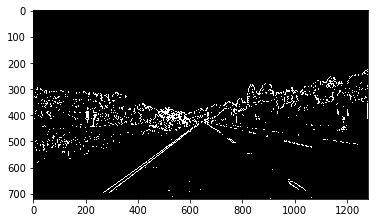

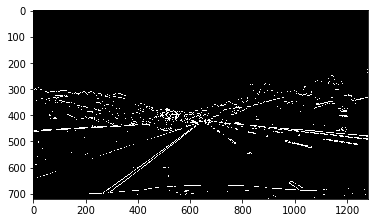

In [30]:
sx_binary = apply_threshholding(sobelx_norm, 25, 200)
sy_binary = apply_threshholding(sobely_norm, 40, 200)

plt.imshow(sx_binary, cmap='gray'); plt.show(); plt.savefig(out + 'lane_line_sobelx_binary.png')
plt.imshow(sy_binary, cmap='gray'); plt.show(); plt.savefig(out + 'lane_line_sobely_binary.png')

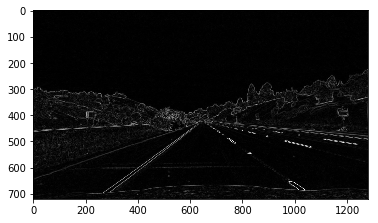

In [31]:
sobel_mag = gradient_magnitude(sobelx, sobely)

plt.imshow(sobel_mag, cmap='gray')
plt.savefig(out + 'lane_line_sobelmag.png')

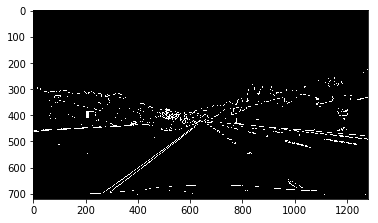

In [32]:
smag_binary = apply_threshholding(sobel_mag, 60, 200)

plt.imshow(smag_binary, cmap='gray')
plt.savefig(out + 'lane_line_sobelmag_binary.png')

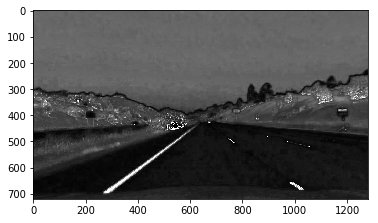

In [33]:
img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.imshow(img_hls[:, :, 2], cmap='gray')
plt.savefig(out + 'lane_line_hls_schannel.png')

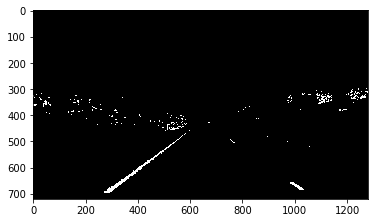

In [34]:
hls_sch_binary = apply_threshholding(img_hls[:, :, 2], 140, 255)

plt.imshow(hls_sch_binary, cmap='gray')
plt.savefig(out + 'lane_line_hls_schannel_binary.png')

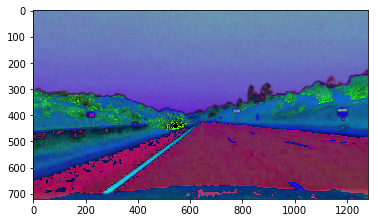

In [35]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.imshow(img_hsv)

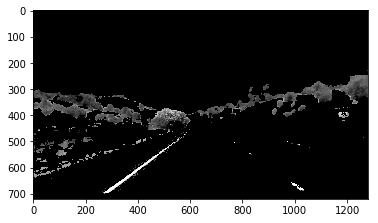

In [36]:
hsv_binary = get_hsv_color_range(img_hsv, [20,0,0], [40,255,255])
v_range_binary = hsv_binary[:, :, 2]

plt.imshow(v_range_binary, cmap='gray')
plt.savefig(out + 'lane_line_hsv_vchannel.png')

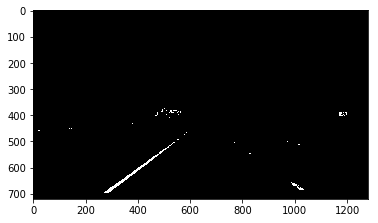

In [37]:
hsv_range_binary = apply_threshholding(hsv_binary[:, :, 2], 180, 255)

plt.imshow(hsv_range_binary, cmap='gray')
plt.savefig(out + 'lane_line_hsv_vchannel_binary.png')

## use all binary mask

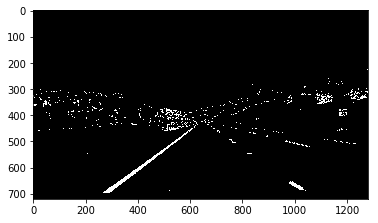

In [38]:
binary = np.zeros_like(hsv_range_binary)
binary[((sx_binary == 1) & (sy_binary == 1) & (smag_binary == 1)) | 
       (hls_sch_binary == 1) | (hsv_range_binary == 1)] = 1

plt.imshow(binary, cmap='gray')
plt.savefig(out + 'lane_line_all_binary.png')

### make function

In [39]:
cfg = {
    'sobelx': {
        'min': 25,
        'max': 200
    },
    'sobely': {
        'min': 40,
        'max': 200
    },
    'sobelmag': {
        'min': 60,
        'max': 200,
    },
    'hls': {
        'min': 140,
        'max': 255
    },
    'hsv': {
        'color_range_min': [20, 0, 0],
        'color_range_max': [40, 255, 255],
        'min': 180,
        'max': 255
    }
}

In [40]:
def get_binary_mask_from_image(img, cfg):
    
    # convert BGR to Gray scale for gradient calculation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sobel filter
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = gradient_magnitude(sobelx, sobely)
    
    sobelx_norm = sobel_filter(sobelx)
    sobely_norm = sobel_filter(sobely)
    
    sx_binary = apply_threshholding(sobelx_norm, cfg['sobelx']['min'], cfg['sobelx']['max'])
    sy_binary = apply_threshholding(sobely_norm, cfg['sobely']['min'], cfg['sobely']['max'])
    smag_binary = apply_threshholding(sobel_mag, cfg['sobelmag']['min'], cfg['sobelmag']['max'])
    
    # COLOR(HLS) Threshholding
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls_sch_binary = apply_threshholding(img_hls[:, :, 2], cfg['hls']['min'], cfg['hls']['max'])
    
    # COLOR(HSV) Threshholding
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_binary = get_hsv_color_range(img_hsv, 
                                     cfg['hsv']['color_range_min'], 
                                     cfg['hsv']['color_range_max'])
    hsv_range_binary = apply_threshholding(hsv_binary[:, :, 2], cfg['hsv']['min'], cfg['hsv']['max'])
    
    # get binary mask
    binary = np.zeros_like(hsv_range_binary)
    binary[((sx_binary == 1) & (sy_binary == 1) & (smag_binary == 1)) | 
           (hls_sch_binary == 1) | 
           (hsv_range_binary == 1)] = 1
    
    return binary

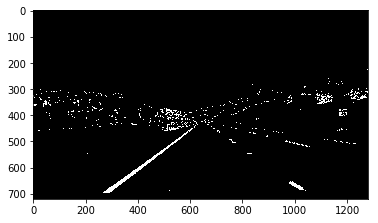

In [41]:
plt.imshow(
    get_binary_mask_from_image(cv2.imread(test_images_path[0]), cfg),
    cmap='gray'
)

In [42]:
with open('experimental/cfg.pickle', 'wb') as f:
    pickle.dump(cfg, f)

## apply perspective transform

In [43]:
with open('./experimental/perspective_mtx.pickle', 'rb') as f:
    perspective_mtx = pickle.load(f)

In [44]:
M = perspective_mtx['M']
MInv = perspective_mtx['MInv']

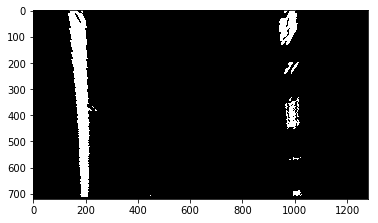

In [45]:
binary_warped = cv2.warpPerspective(binary, M, binary.shape[::-1])

plt.imshow(binary_warped, cmap='gray')
plt.savefig(out + 'lane_line_warped_binary.png')

## Lane Finding

### peak

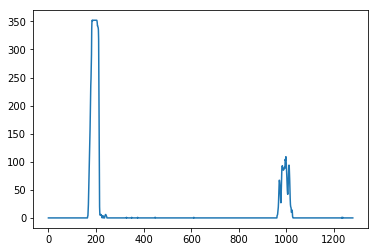

In [46]:
bottom_half = binary_warped[binary_warped.shape[0]//2:, :]
histogram = np.sum(bottom_half, axis=0)
plt.plot(histogram)

In [47]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

In [48]:
midpoint = np.int(histogram.shape[0] // 2)
midpoint

640

In [49]:
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

leftx_base, rightx_base

(184, 998)

In [50]:
nwindows = 9
margin = 100
minpix = 50

In [51]:
window_height = np.int(binary_warped.shape[0] // nwindows)
window_height

80

In [52]:
nonzero = binary_warped.nonzero()
nonzero

(array([  0,   0,   0, ..., 713, 713, 715]),
 array([ 138,  139,  140, ..., 1233, 1237,  611]))

In [53]:
# Caution!! Wrong Order Y-x
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [54]:
leftx_current = leftx_base
rightx_current = rightx_base

In [55]:
left_lane_inds = []
right_lane_inds = []

height, width = binary_warped.shape

for window in range(nwindows):
    
    win_y_low  = height - (window + 1) * window_height
    win_y_high = height - window     * window_height
    
    win_xleft_low  = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low  = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img, (win_xleft_low, win_y_low),
        (win_xleft_high, win_y_high), (0, 255, 0), 2) 
    cv2.rectangle(out_img, (win_xright_low, win_y_low),
        (win_xright_high, win_y_high), (0, 255, 0), 2) 
    
    good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    

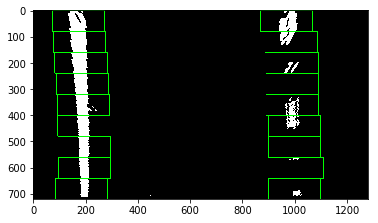

In [56]:
plt.imshow(out_img)

In [57]:
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

In [58]:
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [59]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [60]:
left_fit

array([ -6.32934051e-05,   9.21270872e-02,   1.63496851e+02])

In [61]:
right_fit

array([  5.57683045e-05,   1.44787697e-02,   9.74484841e+02])

In [62]:
ploty = np.linspace(0, height-1, height)

In [63]:
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [64]:
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

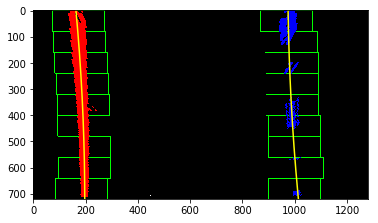

In [65]:
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.savefig(out + 'lane_line_warped_detect_line.png')

In [66]:
left_line_window1 = np.array(np.transpose(np.vstack([left_fitx-margin, ploty])))
left_line_window1

array([[  63.49685149,    0.        ],
       [  63.58891529,    1.        ],
       [  63.68085249,    2.        ],
       ..., 
       [  97.0135297 ,  717.        ],
       [  97.01483075,  718.        ],
       [  97.01600522,  719.        ]])

In [67]:
np.transpose(np.vstack([left_fitx+margin, ploty]))

array([[ 263.49685149,    0.        ],
       [ 263.58891529,    1.        ],
       [ 263.68085249,    2.        ],
       ..., 
       [ 297.0135297 ,  717.        ],
       [ 297.01483075,  718.        ],
       [ 297.01600522,  719.        ]])

In [68]:
np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))

array([[ 297.01600522,  719.        ],
       [ 297.01483075,  718.        ],
       [ 297.0135297 ,  717.        ],
       ..., 
       [ 263.68085249,    2.        ],
       [ 263.58891529,    1.        ],
       [ 263.49685149,    0.        ]])

In [69]:
left_line_window2 = np.array(np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty]))))

In [70]:
np.hstack((left_line_window1, left_line_window2))

array([[  63.49685149,    0.        ,  297.01600522,  719.        ],
       [  63.58891529,    1.        ,  297.01483075,  718.        ],
       [  63.68085249,    2.        ,  297.0135297 ,  717.        ],
       ..., 
       [  97.0135297 ,  717.        ,  263.68085249,    2.        ],
       [  97.01483075,  718.        ,  263.58891529,    1.        ],
       [  97.01600522,  719.        ,  263.49685149,    0.        ]])

In [71]:
np.hstack((left_line_window1, left_line_window2)).shape

(720, 4)

In [72]:
np.vstack((left_line_window1, left_line_window2)).shape

(1440, 2)

In [73]:
left_line_pts = np.vstack((left_line_window1, left_line_window2))

In [74]:
right_line_window1 = np.array(np.transpose(np.vstack([right_fitx-margin, ploty])))
right_line_window2 = np.array(np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty]))))
right_line_pts = np.vstack((right_line_window1, right_line_window2))

In [75]:
out_img.shape

(720, 1280, 3)

In [76]:
window_img = np.zeros_like(out_img)
window_img.shape

(720, 1280, 3)

In [77]:
np.int_([left_line_pts])

array([[[ 63,   0],
        [ 63,   1],
        [ 63,   2],
        ..., 
        [263,   2],
        [263,   1],
        [263,   0]]])

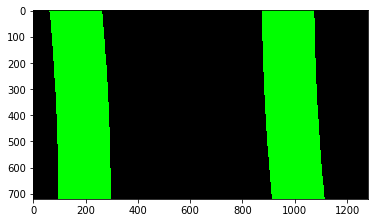

In [78]:
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

plt.imshow(window_img)

In [79]:
img_inv = cv2.warpPerspective(window_img, MInv, window_img.shape[::-1][1:])

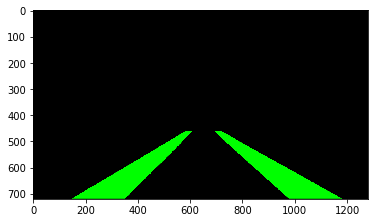

In [80]:
plt.imshow(img_inv)

In [81]:
mpimg.imread(test_images_path[0]).shape, type(mpimg.imread(test_images_path[0]))

((720, 1280, 3), numpy.ndarray)

In [82]:
test = np.random.randint(0, 255, size=(250, 400))
test.shape

(250, 400)

### make function

In [83]:
def get_leftx_rightx_base(binary):
    
    # get bottom_half position
    bottom_half = binary[binary.shape[0] // 2:, :]
    
    # get histogram along y-axis
    histogram = np.sum(bottom_half, axis=0)
    
    # get x-axis position of both lane line
    midpoint = int(binary.shape[1] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

In [84]:
get_leftx_rightx_base(binary_warped)

(184, 998)

In [85]:
def get_left_right_lane_xy(binary, leftx_base, rightx_base):
    
    height, width = binary.shape
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary.shape[0] // nwindows)
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    nonzero = binary.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        
        win_y_low  = height - (window + 1) * window_height
        win_y_high = height - window       * window_height
        
        win_xleft_low   = leftx_current  - margin
        win_xleft_high  = leftx_current  + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # get y-axis index of lane line pixel
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy <= win_y_high) &
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy <= win_y_high) &
                           (nonzerox >= win_xright_low) & 
                           (nonzerox <= win_xright_high)).nonzero()[0]
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [86]:
leftx_base, rightx_base = get_leftx_rightx_base(binary_warped)
leftx, lefty, rightx, righty = get_left_right_lane_xy(binary_warped, 
                                                      leftx_base, 
                                                      rightx_base)

In [87]:
def get_fitting_lane_line_position(leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, height-1, height)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [88]:
left_fitx, right_fitx, ploty = get_fitting_lane_line_position(leftx, lefty, 
                                                              rightx, righty)

In [89]:
def plot_lane_pixel(binary, leftx, lefty, rightx, righty):
    
    out_img = np.dstack((binary, binary, binary)) * 255
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    left_fitx, right_fitx, ploty = get_fitting_lane_line_position(leftx, lefty,
                                                                  rightx, righty)
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

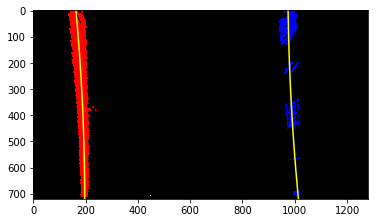

In [90]:
plot_lane_pixel(binary_warped, leftx, lefty, rightx, righty)

In [91]:
def get_lane_pts_for_fillPoly(left_fitx, right_fitx, ploty):
    left_lane_pts  = np.array([left_fitx[::-1], ploty[::-1]]).T
    right_lane_pts = np.array([right_fitx, ploty]).T
    
    lane_pts = np.vstack((left_lane_pts, right_lane_pts))
    
    return lane_pts

In [92]:
def get_lane_rectangle_image(binary, lane_pts):
        
    out_binary = np.zeros_like(binary)
    out_img = np.dstack((out_binary, out_binary, out_binary)) * 255
    
    cv2.fillPoly(out_img, np.int_([lane_pts]), (0, 255, 0))
    
    return out_img

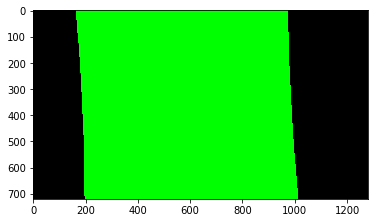

In [93]:
lane_pts = get_lane_pts_for_fillPoly(left_fitx, right_fitx, ploty)
plt.imshow(
    get_lane_rectangle_image(binary_warped, lane_pts),
    cmap='gray'
)

In [94]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):

    return cv2.addWeighted(initial_img, α, img, β, γ)

In [96]:
def lane_finding(path, cfg, perspective_mtx):
    
    img = cv2.imread(path)
    im_size = img.shape[::-1][1:]
    
    binary = get_binary_mask_from_image(img, cfg)
    
    M = perspective_mtx['M']
    MInv = perspective_mtx['MInv']
    binary_warped = cv2.warpPerspective(binary, M, binary.shape[::-1])
    
    leftx_base, rightx_base = get_leftx_rightx_base(binary_warped)
    
    leftx, lefty, rightx, righty = get_left_right_lane_xy(binary_warped, 
                                                          leftx_base, 
                                                          rightx_base)
    
    left_fitx, right_fitx, ploty = get_fitting_lane_line_position(leftx, lefty, 
                                                                  rightx, righty)
    
    lane_pts = get_lane_pts_for_fillPoly(left_fitx, right_fitx, ploty)
    
    img_lane_warped = get_lane_rectangle_image(binary_warped, lane_pts)
    
    img_lane = cv2.warpPerspective(img_lane_warped, MInv, im_size)
    
    out_img = weighted_img(img_lane, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return out_img

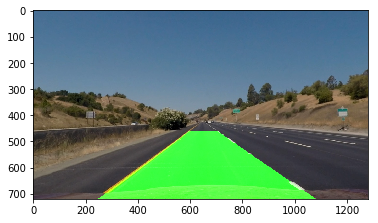

In [98]:
plt.imshow(
    lane_finding(
        test_images_path[0],
        cfg,
        perspective_mtx
    )
)
plt.savefig(out + 'lane_line_lane_line.png')